### The goal of this notebook is to identify which Bedmap1 points are covered by other datasets

In [1]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import importlib
import numpy as np
import os
import pathlib
import pyproj
import scipy.spatial
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`


In [2]:
import detangle_bedmap_utils
importlib.reload(detangle_bedmap_utils)
from detangle_bedmap_utils import (expand_range, find_closest_bedmap,
                                   load_bedmap_ll, load_bedmap_xy_new, 
                                   subsample_tracks_uniform, 
                                  )

In [3]:
bm1_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP1/BEDMAP1_1966-2000_AIR_BM1.csv"
bm1 = load_bedmap_xy_new(bm1_path)

In [4]:
bm1.shape

(1905050, 2)

## Load all BAS surveys of interest.

There were surveys in both BM1 and the BM2 CSVs:
* 1994_Evans
* 1998_Dufek

As well as a number of surveys in the RESPAC release.

In [6]:
def load_respac_surveys(filepath):
    """
    The raw data was provided in a format I haven't seen before.
    There are labeled columns, with different campaigns separated by a single line saying "Line ####"
    """
    seasons = {}
    season = None
    curr_line = None
    ps71 = pyproj.Proj('epsg:3031')
    with open(filepath, "r") as fp:
        for line in fp:
            if line.startswith('/'):
                continue
            if "Line" in line:
                season = line.split()[1]
                if curr_line is not None:
                    lon, lat = zip(*curr_line)
                    xx, yy = ps71.transform(lon, lat)
                    seasons[season] = np.array([xx, yy]).transpose()
                curr_line = []
            else:
                tokens = line.split()
            
                current_record, season, lon, lat, xx, yy, wgs84_height, tice, srfelev, bedelev = tokens
                try:
                    curr_line.append((float(lon), float(lat)))
                except Exception as ex:
                    # Some records don't have position data; just skip them.
                    continue
            
    return seasons
        

In [7]:
respac_filepath = "/Users/lindzey/RadarData/ANTARCTIC/BAS/BAS_RESPAC_Radar.xyz"
bas_points = load_respac_surveys(respac_filepath)

In [8]:
duplicate_bm2_surveys = ["BAS_1994_Evans_AIR_BM2", "BAS_1998_Dufek_AIR_BM2"]

In [9]:
for idx, survey in enumerate(duplicate_bm2_surveys):
    bas_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP2/{}.csv".format(survey)
    bas_points[survey] = load_bedmap_xy_new(bas_path)

In [10]:
bas_points.keys()

dict_keys(['6970', '7172', '7475', '8081', '8283', '8384', '8485', '8586', '8788', 'BAS_1994_Evans_AIR_BM2', 'BAS_1998_Dufek_AIR_BM2'])

## For each survey, try to match up bedmap points

In [11]:
import time

bm1_tree = scipy.spatial.KDTree(bm1)
selected_idxs = {}

for season, ss in bas_points.items():
#for season in ['7172']:
    ss = bas_points[season]
    print("Processing {}".format(season))
        
        
    t0 = time.time()
    season_tree = scipy.spatial.KDTree(ss)
    t1 = time.time()
    bedmap_from_season_dists, bedmap_from_season_idxs = bm1_tree.query(ss, k=1)
    season_from_bedmap_dists, season_from_bedmap_idxs = season_tree.query(bm1, k=1)
    t2 = time.time()
    print("Found closest indices. construction dt = {}, query dt = {}".format(t1-t0, t2-t1))
    
    # Map index to season points to index of closest point in bedmap
    bedmap_from_season = {idx: val for idx, val in enumerate(bedmap_from_season_idxs)}  
    # Maps index to Bedmap1 to closest point in the season. 
    season_from_bedmap = {idx: val for idx, val in enumerate(season_from_bedmap_idxs)}  
    
    max_dist = 1
    candidate_bedmap_idxs, = np.where(season_from_bedmap_dists < max_dist)
    selected_idxs[season] = candidate_bedmap_idxs
    
    print("starting out with {} bedmap points with a neighbor within {:0.3f} km".format(len(candidate_bedmap_idxs), max_dist / 1000))
    mutual_idxs = [idx for idx in candidate_bedmap_idxs if bedmap_from_season[season_from_bedmap[idx]] == idx]
    print("{} of those are mutual.".format(len(mutual_idxs)))
    #non_mutual_idxs = np.setdiff1d(candidate_bedmap_idxs, mutual_idxs)
    
    dt = time.time() - t0
    print("... {:0.2f} seconds".format(dt))    


Processing 6970
Found closest indices. construction dt = 0.0014603137969970703, query dt = 3.3720438480377197
starting out with 1330 bedmap points with a neighbor within 0.001 km
1330 of those are mutual.
... 3.51 seconds
Processing 7172
Found closest indices. construction dt = 0.0026040077209472656, query dt = 4.775110960006714
starting out with 2454 bedmap points with a neighbor within 0.001 km
2454 of those are mutual.
... 4.95 seconds
Processing 7475
Found closest indices. construction dt = 0.0026531219482421875, query dt = 2.7458198070526123
starting out with 5006 bedmap points with a neighbor within 0.001 km
3794 of those are mutual.
... 2.91 seconds
Processing 8081
Found closest indices. construction dt = 0.012440204620361328, query dt = 5.1724138259887695
starting out with 23400 bedmap points with a neighbor within 0.001 km
23400 of those are mutual.
... 5.36 seconds
Processing 8283
Found closest indices. construction dt = 0.00683903694152832, query dt = 5.064254999160767
start

## Plot the results


In [13]:
bm1.shape

(1905050, 2)

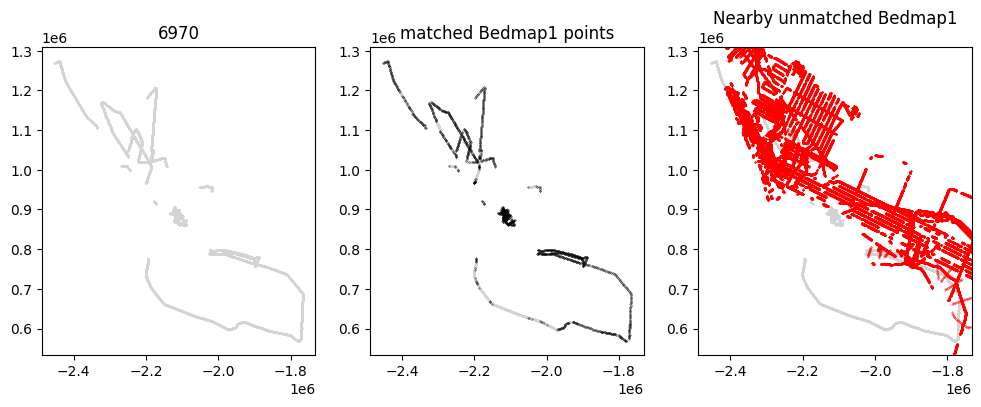

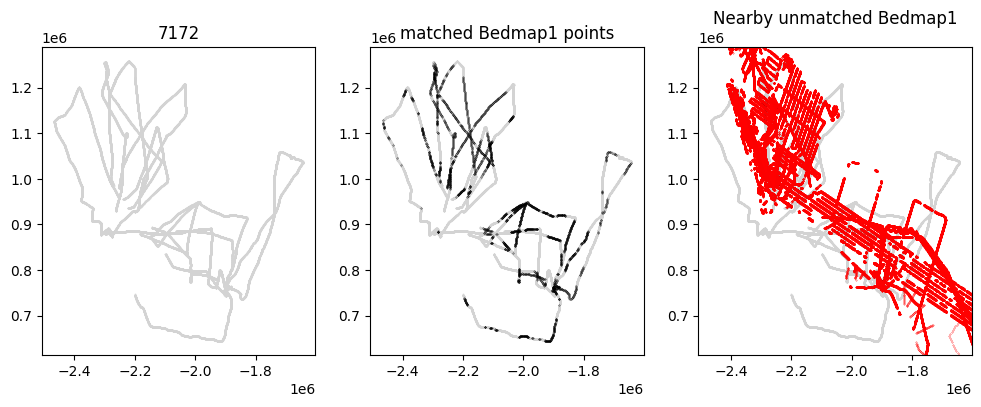

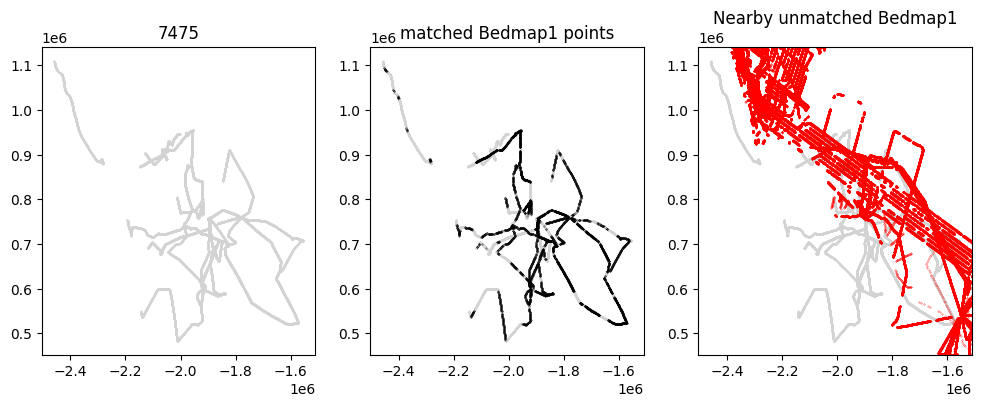

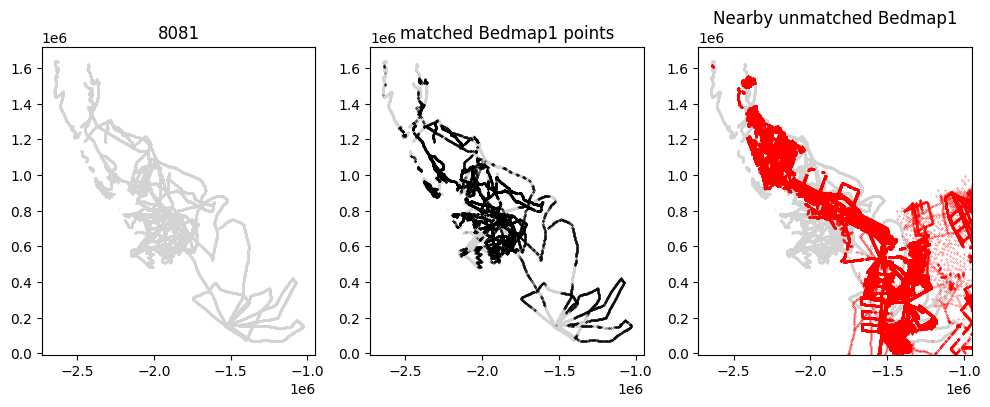

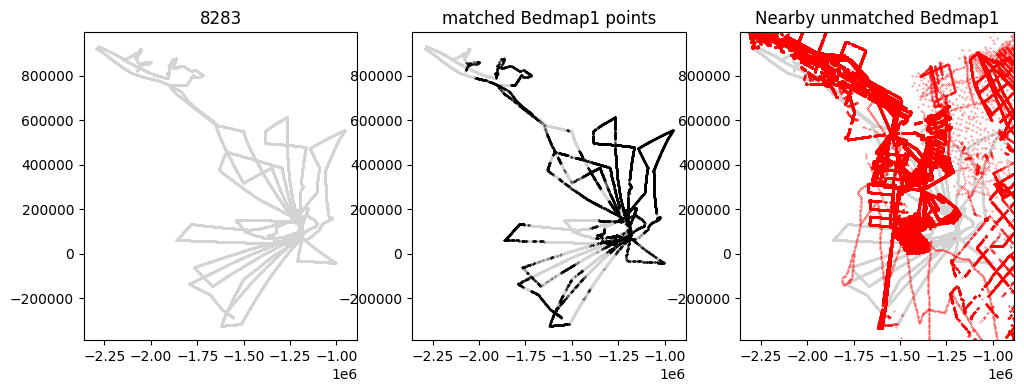

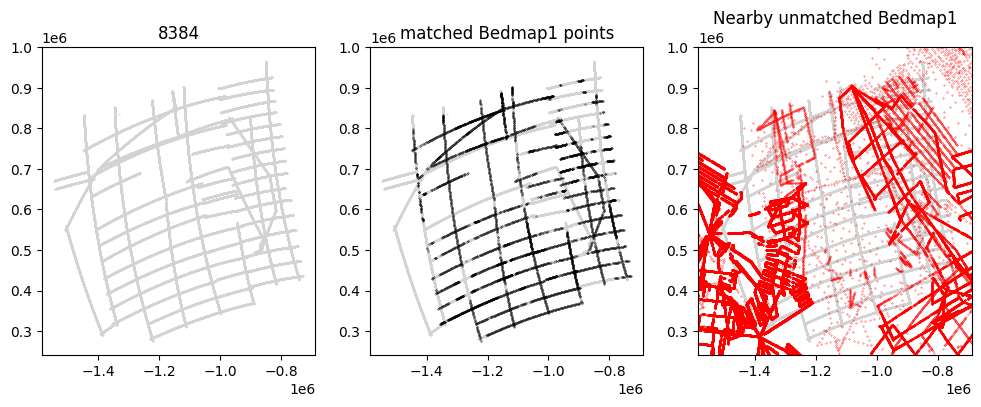

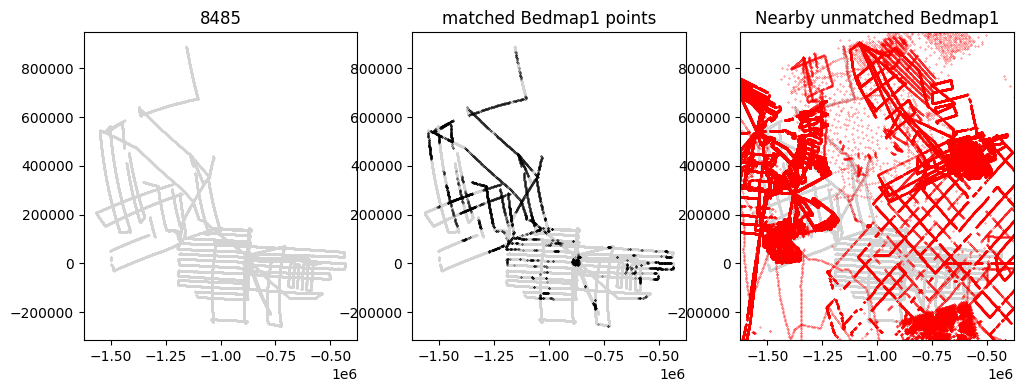

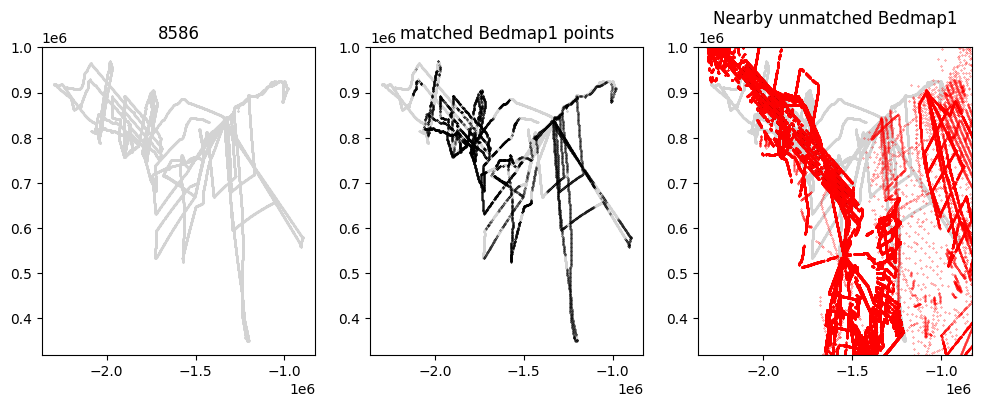

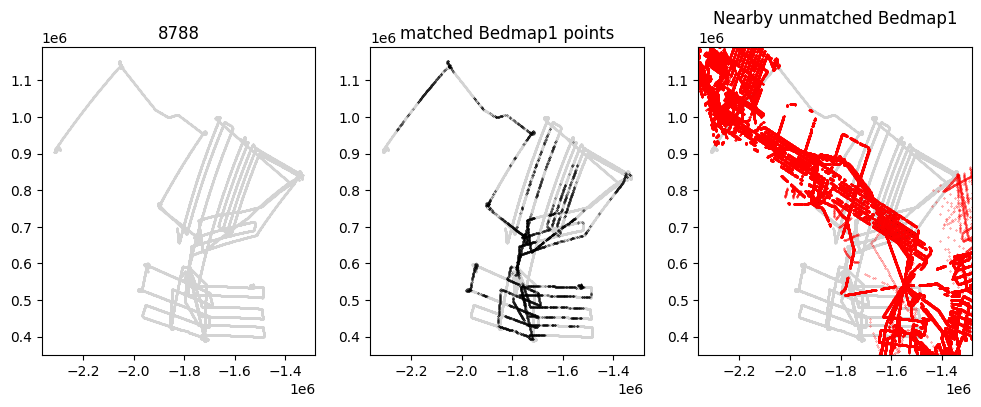

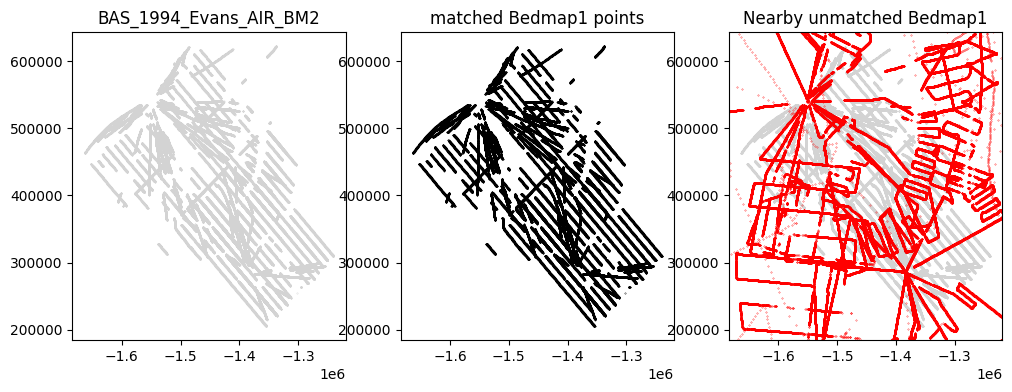

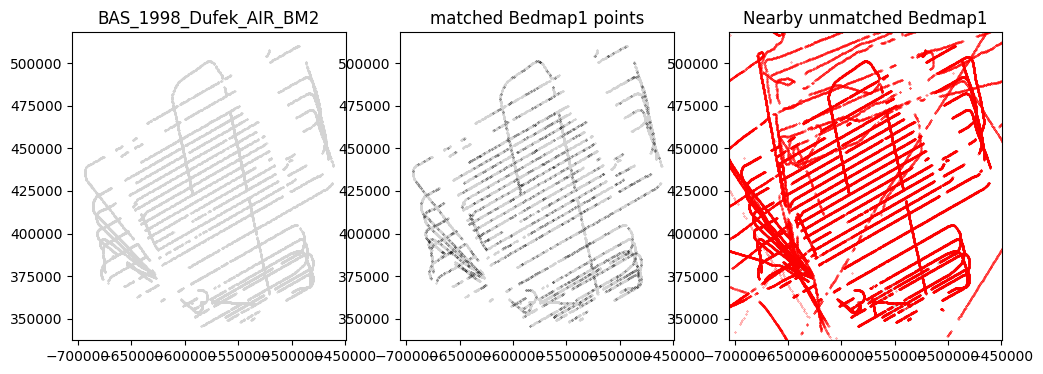

In [14]:
# Find indices that aren't in ANY of our surveys
bm1_rejected_idxs = None
for survey, idxs in selected_idxs.items():
    if bm1_rejected_idxs is None:
        bm1_rejected_idxs = np.arange(0, bm1.shape[0])

    bm1_rejected_idxs = np.setdiff1d(bm1_rejected_idxs, idxs)


for survey, idxs in selected_idxs.items():

    # TODO: Right now, I don't have a way to track back and see which survey points were being selected.
    #survey_match_idxs = [closest_points[survey][ii] for ii in bm1_match_idxs]
    
    fig = plt.figure(figsize=(12, 4))
    ax1, ax2, ax3 = fig.subplots(1,3)

    sx = bas_points[survey][:,0]
    sy = bas_points[survey][:,1]
    
    # Plot the closest points in the survey
    ax1.plot(sx, sy, '.', color='lightgrey', markersize=0.5)
    #ax1.scatter(sx[survey_match_idxs], sy[survey_match_idxs], c=survey_match_idxs)
    ax1.set_title(survey)

    # Plot the selected/rejected bedmap points
    ax2.plot(sx, sy, '.', color='lightgrey', markersize=0.5)
    ax2.plot(bm1[idxs,0], bm1[idxs,1], 'k.', markersize=0.5)
    ax2.set_title("matched Bedmap1 points")

    ax3.plot(sx, sy, '.', color='lightgrey', markersize=0.5)
    ax3.plot(bm1[bm1_rejected_idxs,0], bm1[bm1_rejected_idxs,1], 'r.', markersize=0.5)
    ax3.set_xlim(ax2.get_xlim())
    ax3.set_ylim(ax2.get_ylim())
    ax3.set_title("Nearby unmatched Bedmap1")
    plt.show()
    


All of these look good, other than 1998_Dufek. 

On closer investigation, that one has problems in the underlying data, so I'm not going to try to improve the processing to handle it.

https://github.com/qiceradar/radar_wrangler/issues/9

## Export indices 

... in format suitable for `duplicate_segments`

In [15]:
import importlib
import detangle_bedmap_utils
importlib.reload(detangle_bedmap_utils)

from detangle_bedmap_utils import segment_indices

In [16]:
bm1_matched_idxs = np.array([])
for survey, idxs in selected_idxs.items():
    bm1_matched_idxs = np.union1d(bm1_matched_idxs, idxs)
bm1_matched_idxs = bm1_matched_idxs.astype(int)
bm1_segments = segment_indices(bm1_matched_idxs, 1, 1)

In [17]:
print(bm1_segments)

[(829, 863), (20659, 21958), (21960, 22188), (22190, 22870), (22872, 22916), (22918, 22962), (22964, 23190), (23192, 23327), (23329, 23373), (23375, 23419), (23421, 23465), (23467, 24012), (24014, 24194), (24196, 24240), (24242, 24469), (24471, 24652), (24654, 24788), (24790, 24970), (24972, 25106), (25108, 25289), (25291, 25517), (25519, 25563), (25565, 25747), (25749, 25793), (25795, 26021), (26023, 26113), (26115, 26204), (26206, 26250), (26252, 26296), (26298, 26342), (26344, 26433), (26435, 26479), (26481, 26571), (26573, 26845), (26847, 26891), (26893, 27301), (27303, 27347), (27349, 27393), (27395, 27802), (27804, 27985), (27987, 28076), (28078, 28214), (28216, 28489), (28491, 28626), (28628, 28672), (28674, 29084), (29086, 29175), (29177, 29267), (29269, 29678), (29680, 30598), (30600, 30734), (30736, 30780), (30782, 30918), (30920, 31377), (31379, 31423), (31425, 31560), (31562, 31832), (31834, 32060), (32062, 32106), (32108, 32152), (32154, 32471), (32473, 33247), (33249, 335

## Why are there so many places where a single index is skipped?

In [18]:
# Manually identified the two longest ranges with short gaps.
range1 = np.arange(20659, 73982)
range2 = np.arange(1466288, 1476448)
all_ranges = np.union1d(range1, range2)
skipped_idxs = np.setdiff1d(all_ranges, bm1_matched_idxs)

In [19]:
skipped_idxs

array([  21959,   22189,   22871,   22917,   22963,   23191,   23328,
         23374,   23420,   23466,   24013,   24195,   24241,   24470,
         24653,   24789,   24971,   25107,   25290,   25518,   25564,
         25748,   25794,   26022,   26114,   26205,   26251,   26297,
         26343,   26434,   26480,   26572,   26846,   26892,   27302,
         27348,   27394,   27803,   27986,   28077,   28215,   28490,
         28627,   28673,   29085,   29176,   29268,   29679,   30599,
         30735,   30781,   30919,   31378,   31424,   31561,   31833,
         32061,   32107,   32153,   32472,   33248,   33524,   33752,
         33798,   33890,   34116,   34208,   34254,   35120,   35166,
         35258,   35714,   35760,   36308,   36535,   37217,   37626,
         37672,   37854,   38219,   38311,   38584,   39174,   39310,
         39401,   39492,   39721,   39767,   39813,   39904,   40268,
         40314,   40862,   40953,   41044,   41181,   41317,   41363,
         41774,   42

In [20]:
bas_points['6970'].shape

(10572, 2)

(-423183.65974999394, 1736447.5906746867)

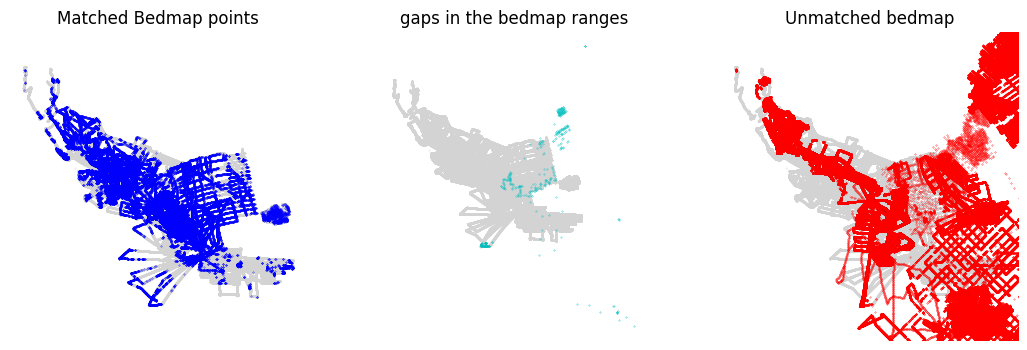

In [21]:
fig = plt.figure(figsize=(13,4))
ax1, ax2, ax3 = fig.subplots(1,3)

for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')

all_xx = []
all_yy = []
for points in bas_points.values():
    all_xx.extend(points[:,0])
    all_yy.extend(points[:,1])

ax1.plot(all_xx, all_yy, '.', markersize=0.5, color='lightgrey')
ax1.plot(bm1[bm1_matched_idxs, 0], bm1[bm1_matched_idxs,1], '.', markersize=0.5, color='blue')
ax1.set_title('Matched Bedmap points')

ax2.plot(all_xx, all_yy, '.', markersize=0.5, color='lightgrey')
ax2.plot(bm1[skipped_idxs,0], bm1[skipped_idxs, 1], 'c.', markersize=0.5)
ax2.set_title('gaps in the bedmap ranges')

ax3.plot(all_xx, all_yy, '.', markersize=0.5, color='lightgrey')
ax3.plot(bm1[bm1_rejected_idxs,0], bm1[bm1_rejected_idxs,1], 'r.', markersize=0.5)
ax3.set_title('Unmatched bedmap')
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())




Yup, looks like those are probably actually outliers, not BAS points.